In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import pickle
import os

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
df=pd.read_csv('forest_fire_dataset_processed.csv')
df.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,BR
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,BR
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,BR
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,BR
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,BR


In [4]:
x=df.drop(columns=['Temperature'])
y=df['Temperature']

In [5]:
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=100) #using same random_state as per EDA

# Training Pipeline

In [6]:
def train_preprocessing_pipeline(x_train, y_train):
    df=pd.concat([x_train, y_train], axis=1)
    df=df.reset_index(drop=True)
    
    #adding features
    df['day_name']=pd.to_datetime(df[['day', 'month', 'year']]).apply(lambda x: x.strftime("%a"))
    df['month']=pd.to_datetime(df[['day', 'month', 'year']]).apply(lambda x: x.strftime("%b"))
    
    #dropping unnecessary column
    df=df.drop(columns=['year', 'day', 'BUI', 'FWI'])
    
    #separating data into categorical and numerical values
    num_df=df.drop(columns=['month', 'day_name', 'Classes', 'Region', 'Temperature'])
    cat_df=df[['month', 'day_name', 'Classes', 'Region']]
    
    output_df=df['Temperature']
    
    #scaling
    scaler=StandardScaler()
    num_array=scaler.fit_transform(num_df)
    num_df=pd.DataFrame(num_array, columns=num_df.columns)
    if not os.path.isdir('Scaling'):
        os.mkdir('Scaling')
    pickle.dump(scaler, open('Scaling/Scaler_Regression.pickle', 'wb'))
    
    #encoding
    cat_df['month']=cat_df['month'].map({'Aug':3, 'Jul':2, 'Jun':1, 'Sep':0})  
    cat_df['Region']=cat_df['Region'].map({'SBAR':1, 'BR':0})
    cat_df['Classes']=cat_df['Classes'].map({'fire':1, 'not fire':0})
    encoder=pickle.load(open('Encoder/encode_dayname.pickle', 'rb'))
    day_names_array=encoder.transform(cat_df[['day_name']])
    day_names=pd.DataFrame(day_names_array, columns=encoder.get_feature_names_out())
    cat_df=cat_df.drop(columns=['day_name'])
    cat_df=pd.concat([cat_df, day_names], axis=1)
    
    final_data=pd.concat([num_df, cat_df, output_df], axis=1)
    x=final_data.drop(columns=['Temperature'])
    y=final_data['Temperature']
    return x, y

# Testing Pipeline

In [7]:
def test_preprocessing_pipeline(x_test, y_test):
    df=pd.concat([x_test, y_test], axis=1)
    df=df.reset_index(drop=True)
    
    #adding features
    df['day_name']=pd.to_datetime(df[['day', 'month', 'year']]).apply(lambda x: x.strftime("%a"))
    df['month']=pd.to_datetime(df[['day', 'month', 'year']]).apply(lambda x: x.strftime("%b"))
    
    #dropping unnecessary column
    df=df.drop(columns=['year', 'day', 'BUI', 'FWI'])
    num_df=df.drop(columns=['month', 'day_name','Classes', 'Region', 'Temperature'])
    cat_df=df[['month', 'day_name', 'Classes','Region']]
    
    output_df=df['Temperature']
    
    #scaling
    scaler=pickle.load(open('Scaling/Scaler_Regression.pickle', 'rb'))
    num_array=scaler.transform(num_df)
    num_df=pd.DataFrame(num_array, columns=num_df.columns)
    
    #encoding
    cat_df['month']=cat_df['month'].map({'Aug':3, 'Jul':2, 'Jun':1, 'Sep':0})  
    cat_df['Region']=cat_df['Region'].map({'SBAR':1, 'BR':0})
    cat_df['Classes']=cat_df['Classes'].map({'fire':1, 'not fire':0})
    encoder=pickle.load(open('Encoder/encode_dayname.pickle', 'rb'))
    day_names_array=encoder.transform(cat_df[['day_name']])
    day_names=pd.DataFrame(day_names_array, columns=encoder.get_feature_names_out())
    cat_df=cat_df.drop(columns=['day_name'])
    cat_df=pd.concat([cat_df, day_names], axis=1)
    
    final_data=pd.concat([num_df, cat_df, output_df], axis=1)
    x=final_data.drop(columns=['Temperature'])
    y=final_data['Temperature']
    return x,y

# Preprocessed data

In [8]:
train_x, train_y=train_preprocessing_pipeline(x_train, y_train)
test_x, test_y = test_preprocessing_pipeline(x_test, y_test)

C:\Users\SAYAN\AppData\Local\Temp/ipykernel_6788/971763646.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['month']=cat_df['month'].map({'Aug':3, 'Jul':2, 'Jun':1, 'Sep':0})
C:\Users\SAYAN\AppData\Local\Temp/ipykernel_6788/971763646.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['Region']=cat_df['Region'].map({'SBAR':1, 'BR':0})
C:\Users\SAYAN\AppData\Local\Temp/ipykernel_6788/971763646.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [10]:
train_x.head()

,RH,Ws,Rain,FFMC,DMC,DC,ISI,month,Classes,Region,day_name_Mon,day_name_Sat,day_name_Sun,day_name_Thu,day_name_Tue,day_name_Wed
0,-0.821244,-0.531608,-0.381541,0.774336,0.669505,0.984429,0.596570,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.254823,-0.192358,-0.381541,0.300430,-0.398234,-0.242187,-0.407116,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.183304,1.164642,-0.104489,-0.626776,-0.737969,-0.727538,-0.765576,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
3,-1.156094,0.486142,-0.381541,0.897963,0.273147,-0.531191,1.480770,2,1,1,0.0,0.0,1.0,0.0,0.0,0.0
4,1.187853,-0.192358,-0.381541,0.389717,-0.543834,-0.301753,-0.287630,0,1,1,0.0,0.0,1.0,0.0,0.0,0.0


In [11]:
test_x.head()

,RH,Ws,Rain,FFMC,DMC,DC,ISI,month,Classes,Region,day_name_Mon,day_name_Sat,day_name_Sun,day_name_Thu,day_name_Tue,day_name_Wed
0,0.183304,-0.870858,-0.381541,0.643840,-0.284989,-0.407647,0.118624,3,1,0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.120883,-0.192358,-0.381541,0.547685,1.122485,1.937482,-0.000862,2,1,0,1.0,0.0,0.0,0.0,0.0,0.0
2,-1.557913,-0.192358,-0.289191,0.815545,0.095191,-0.281897,0.835543,3,1,1,0.0,0.0,0.0,0.0,0.0,0.0
3,1.455733,0.825392,-0.381541,0.437794,-0.090855,0.024757,-0.048657,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.486395,-1.549358,-0.381541,0.712522,0.151813,0.214485,0.166419,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Training

## LinearRegression

In [14]:
lr=LinearRegression()
lr.fit(train_x, train_y)

LinearRegression()

In [15]:
pred_lr_y=lr.predict(test_x).astype(int)

mse_lr=np.round(mean_squared_error(test_y, pred_lr_y),3)
r2_lr=np.round(r2_score(test_y, pred_lr_y),3)

print('MSE: ', mse_lr)
print('r2_score: ', r2_lr)

MSE:  3.592
r2_score:  0.694


## Ridge

In [17]:
param_grid_ridge={
    "alpha" : np.arange(0, 10, 0.5)
}

grid_search_ridge=GridSearchCV(Ridge(), param_grid_ridge, cv=5)
grid_search_ridge.fit(train_x, train_y)
grid_search_ridge.best_params_

{'alpha': 9.5}

In [18]:
ridge=Ridge(alpha=9.5)
ridge.fit(train_x, train_y)

Ridge(alpha=9.5)

In [19]:
pred_ridge_y=ridge.predict(test_x).astype(int)

mse_ridge=np.round(mean_squared_error(test_y, pred_ridge_y),3)
r2_ridge=np.round(r2_score(test_y, pred_ridge_y),3)

print('MSE: ', mse_ridge)
print('r2_score: ', r2_ridge)

MSE:  3.184
r2_score:  0.729


## Lasso

In [20]:
param_grid_lasso={
    "alpha" : np.arange(0.1, 10, 0.1)
}

grid_search_lasso=GridSearchCV(Lasso(), param_grid_lasso, cv=5)
grid_search_lasso.fit(train_x, train_y)
grid_search_lasso.best_params_

{'alpha': 0.1}

In [21]:
lasso=Lasso(alpha=0.1)
lasso.fit(train_x, train_y)

Lasso(alpha=0.1)

In [22]:
pred_lasso_y=lasso.predict(test_x).astype(int)

mse_lasso=np.round(mean_squared_error(test_y, pred_lasso_y),3)
r2_lasso=np.round(r2_score(test_y, pred_lasso_y),3)

print('MSE: ', mse_lasso)
print('r2_score: ', r2_lasso)

MSE:  3.367
r2_score:  0.713


## SVR

### Model svr1

In [71]:
param_grid_svr1={
    "kernel" : ["rbf"],
    "gamma" : ["scale", "auto"],
    "C":[2.0, 1.5, 1.0, 0.5, 0.1, 0.05, 0.01],
    "epsilon" : np.arange(0.1,5,0.1)   
}

grid_search_svr1=GridSearchCV(SVR(), param_grid_svr1, cv=5)
grid_search_svr1.fit(train_x, train_y)
grid_search_svr1.best_params_

{'C': 2.0, 'epsilon': 0.9, 'gamma': 'auto', 'kernel': 'rbf'}

In [72]:
svr1=SVR(C=2.0, kernel="rbf", epsilon=0.9, gamma='auto')
svr1.fit(train_x, train_y)

SVR(C=2.0, epsilon=0.9, gamma='auto')

In [75]:
pred_svr_y1=svr1.predict(test_x).astype(int)

mse_svr1=np.round(mean_squared_error(test_y, pred_svr_y1),3)
r2_svr1=np.round(r2_score(test_y, pred_svr_y1),3)

print('MSE: ', mse_svr1)
print('r2_score: ', r2_svr1)

MSE:  3.102
r2_score:  0.736


### Model svr2

In [76]:
param_grid_svr2={
    "kernel" : ["linear"],
    "C":[2.0, 1.5, 1.0, 0.5, 0.1, 0.05, 0.01],
    "epsilon" : np.arange(0.1,5,0.1)
}

grid_search_svr2=GridSearchCV(SVR(), param_grid_svr2, cv=5)
grid_search_svr2.fit(train_x, train_y)
grid_search_svr2.best_params_

{'C': 0.1, 'epsilon': 1.6, 'kernel': 'linear'}

In [79]:
svr2=SVR(C=0.1, kernel="linear", epsilon=1.6)
svr2.fit(train_x, train_y)

SVR(C=0.1, epsilon=1.6, kernel='linear')

In [80]:
pred_svr_y2=svr2.predict(test_x).astype(int)

mse_svr2=np.round(mean_squared_error(test_y, pred_svr_y2),3)
r2_svr2=np.round(r2_score(test_y, pred_svr_y2),3)

print('MSE: ', mse_svr2)
print('r2_score: ', r2_svr2)

MSE:  3.592
r2_score:  0.694


# 📌

Model svr1 is better between two SVR model   

## DecissionTree

In [123]:
param_grid_dt={
    "criterion" : ["squared_error", "absolute_error"],
    "min_samples_leaf" : [3, 5, 8, 10],
    "max_features" : ["sqrt", "log2", None],
    "random_state" : [10, 30, 50, 100]
}

grid_search_dt = GridSearchCV(DecisionTreeRegressor(), param_grid_dt, cv=5)
grid_search_dt.fit(train_x, train_y)
grid_search_dt.best_params_

{'criterion': 'absolute_error',
 'max_features': None,
 'min_samples_leaf': 10,
 'random_state': 10}

In [124]:
dt=DecisionTreeRegressor(criterion='absolute_error', min_samples_leaf=10,  max_features=None, random_state=10)
dt.fit(train_x, train_y)

DecisionTreeRegressor(criterion='absolute_error', min_samples_leaf=10,
                      random_state=10)

In [125]:
pred_dt_y=dt.predict(test_x).astype(int)

mse_dt=np.round(mean_squared_error(test_y, pred_dt_y),3)
r2_dt=np.round(r2_score(test_y, pred_dt_y),3)

print('MSE: ', mse_dt)
print('r2_score: ', r2_dt)

MSE:  4.061
r2_score:  0.654


[Text(0.359375, 0.9285714285714286, 'X[3] <= -0.263\nabsolute_error = 2.912\nsamples = 194\nvalue = 32.0'),
 Text(0.125, 0.7857142857142857, 'X[5] <= -0.896\nabsolute_error = 2.203\nsamples = 59\nvalue = 29.0'),
 Text(0.0625, 0.6428571428571429, 'absolute_error = 1.455\nsamples = 11\nvalue = 25.0'),
 Text(0.1875, 0.6428571428571429, 'X[0] <= 1.087\nabsolute_error = 1.833\nsamples = 48\nvalue = 29.0'),
 Text(0.125, 0.5, 'X[1] <= -0.362\nabsolute_error = 1.844\nsamples = 32\nvalue = 30.0'),
 Text(0.0625, 0.35714285714285715, 'absolute_error = 1.692\nsamples = 13\nvalue = 32.0'),
 Text(0.1875, 0.35714285714285715, 'absolute_error = 1.579\nsamples = 19\nvalue = 29.0'),
 Text(0.25, 0.5, 'absolute_error = 1.062\nsamples = 16\nvalue = 28.0'),
 Text(0.59375, 0.7857142857142857, 'X[7] <= 1.5\nabsolute_error = 2.289\nsamples = 135\nvalue = 33.0'),
 Text(0.4375, 0.6428571428571429, 'X[4] <= 0.318\nabsolute_error = 1.981\nsamples = 53\nvalue = 32.0'),
 Text(0.375, 0.5, 'X[0] <= 0.049\nabsolute_err

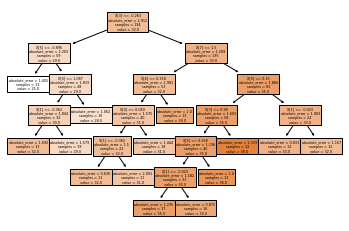

In [126]:
tree.plot_tree(dt, filled=True)

## RandomForest

In [33]:
param_grid_rf={
    "criterion" : ["squared_error", "absolute_error"],
    "min_samples_leaf" : [3, 5, 8, 10],
    "max_features" : ["sqrt", "log2", None],
    "random_state" : [10, 30, 50, 100]

}

grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5)
grid_search_rf.fit(train_x, train_y)
grid_search_rf.best_params_

{'criterion': 'squared_error',
 'max_features': None,
 'min_samples_leaf': 3,
 'random_state': 100}

In [34]:
rf=RandomForestRegressor(criterion='squared_error', min_samples_leaf=3, max_features=None, random_state=100)
rf.fit(train_x, train_y)

RandomForestRegressor(max_features=None, min_samples_leaf=3, random_state=100)

In [35]:
pred_rf_y=rf.predict(test_x).astype(int)

mse_rf=np.round(mean_squared_error(test_y, pred_rf_y),3)
r2_rf=np.round(r2_score(test_y, pred_rf_y),3)

print('MSE: ', mse_rf)
print('r2_score: ', r2_rf)

MSE:  3.531
r2_score:  0.699


## Compairing Models

In [127]:
scores=[("LinearRegression", r2_lr), ("Ridge", r2_ridge), ("Lasso", r2_lasso), ("SVR", r2_svr1), ("DecissionTree" , r2_dt), ("RandomForest" , r2_rf)]
model_report=pd.DataFrame(scores, columns=['Model', 'Score'])

In [128]:
model_report

,Model,Score
0,LinearRegression,0.694
1,Ridge,0.729
2,Lasso,0.713
3,SVR,0.736
4,DecissionTree,0.654
5,RandomForest,0.699


We will choose SVR

## Saving best model

In [129]:
if not os.path.isdir('Models'):
    os.mkdir('Models')
pickle.dump(svr1, open('Models/Model_Regression.pickle', 'wb'))